# Constructing EOS and solving TOV equations

In [1]:
import jax
print(jax.devices())


[CudaDevice(id=0)]


W0115 21:03:59.479099  320169 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0115 21:03:59.481443  320083 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


This example notebook shows how to construct the equation of state with the metamodel and speed-of-sound extension scheme parametrization used in the paper, as well as solve the TOV equations. 

In [2]:
import os
os.environ["JAX_TRACEBACK_FILTERING"] = "off" #want to see all error trace
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)

import jax.numpy as jnp

from jesterTOV.eos import MetaModel_with_CSE_EOS_model, construct_family, construct_family_nonGR, construct_family_ST_Greci#, construct_family_ST_sol
import jesterTOV.utils as utils


import jax
import jax.numpy as jnp
from jax.scipy.special import factorial
from jaxtyping import Array, Float, Int
from jesterTOV import utils, STtov
import time
import os
import jax
import jax.numpy as jnp
from jax.scipy.special import factorial
from jaxtyping import Array, Float, Int
from jesterTOV import utils, STtov



print("Filtering:", os.environ.get("JAX_TRACEBACK_FILTERING"))
print("Current traceback filtering:", jax.config.jax_traceback_filtering)
print(jax.default_backend())



Filtering: off
Current traceback filtering: auto
gpu


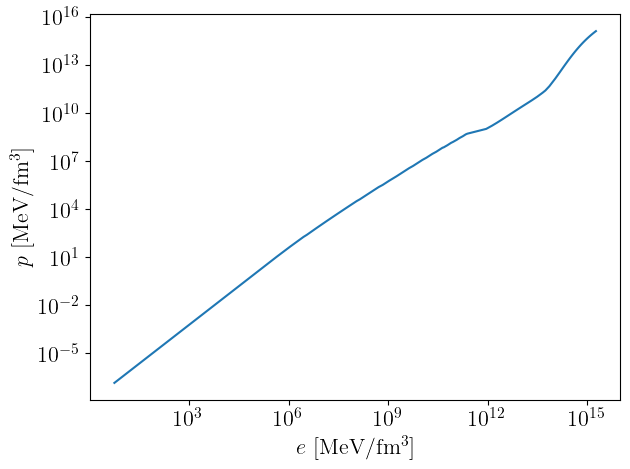

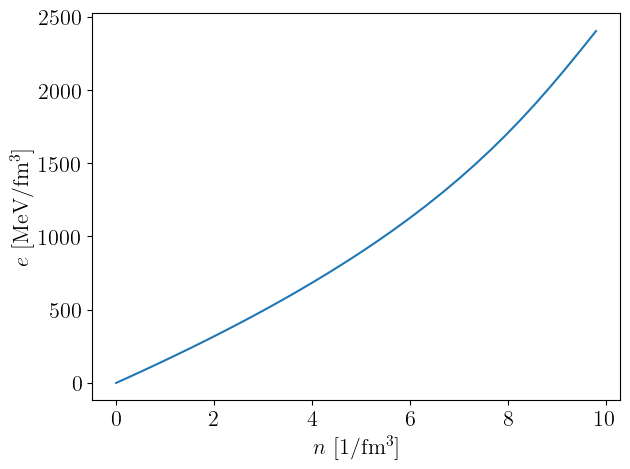

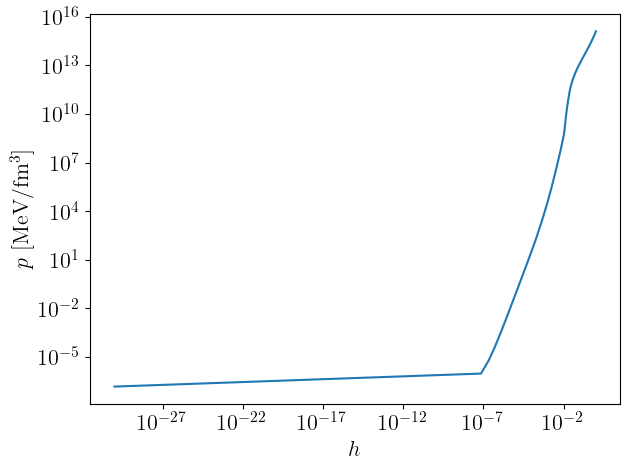

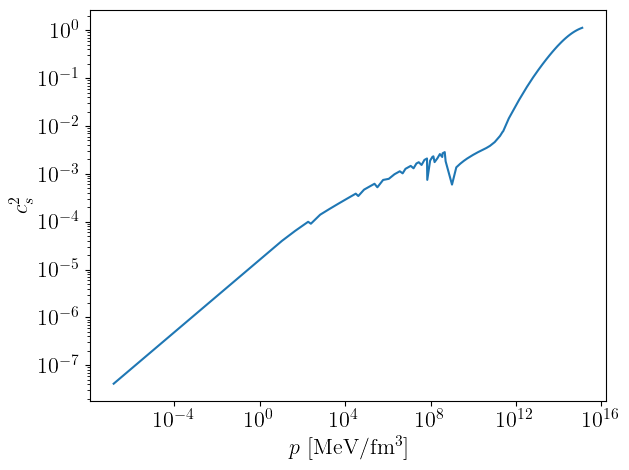

Elapsed time: 4.900129 s


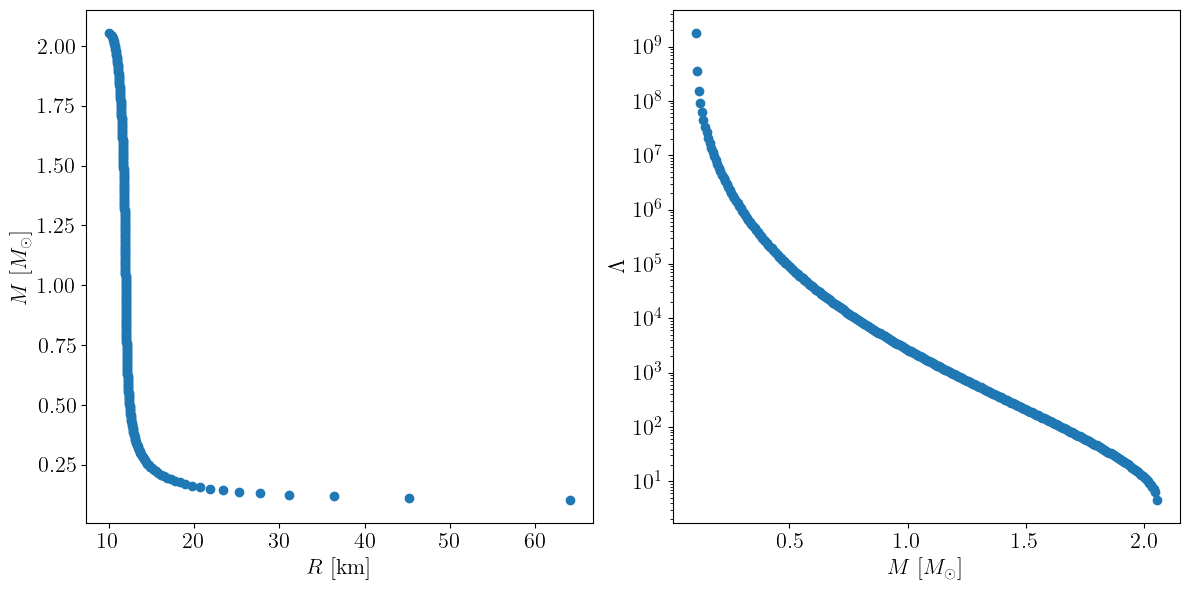

In [3]:
import numpy as np
import requests
from jesterTOV.eos import Interpolate_EOS_model

def fetch_bilby_eos(path):
    # Check if path is a URL or local file
    if path.startswith("http://") or path.startswith("https://"):
        response = requests.get(path)
        response.raise_for_status()  # Raise error if download failed
        lines = response.text.strip().splitlines()
    else:
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
        with open(path, "r") as f:
            lines = f.read().strip().splitlines()

    p_geo, e_geo = [], []
    for line in lines:
        line = line.strip()
        if line.startswith("#") or not line:
            continue
        vals = line.split()
        if len(vals) < 2:
            continue
        try:
            first_val = float(vals[0])
            second_val = float(vals[1])
            if first_val == 0.0:
                continue
            p_geo.append(first_val)
            e_geo.append(second_val)
        except ValueError:
            continue

    # Convert to JAX arrays
    p_geo_jax = jnp.array(p_geo)
    e_geo_jax = jnp.array(e_geo)

    # Calculate rest mass density in geometric units
    n_geo = utils.calculate_rest_mass_density(e_geo_jax, p_geo_jax)

    # Convert to MeV/fm³
    n_MeV = np.array(n_geo) * utils.geometric_to_MeV_fm_inv3 / utils.m
    p_MeV = np.array(p_geo_jax) * utils.geometric_to_MeV_fm_inv3
    e_MeV = np.array(e_geo_jax) * utils.geometric_to_MeV_fm_inv3

    return n_MeV, p_MeV, e_MeV

# --- Usage ---
eos_url = "https://raw.githubusercontent.com/bilby-dev/bilby/main/bilby/gw/eos/eos_tables/LALSimNeutronStarEOS_SLY.dat"
# eos_url = "https://raw.githubusercontent.com/diodaberjalan/I-Love-Curvature-paper-data/refs/heads/main/SLy_poly.dat"
n, p, e = fetch_bilby_eos(eos_url)

# integrate with Jester
eos = Interpolate_EOS_model()
ns, ps, hs, es, dloge_dlogps = eos.interpolate_eos(n, p, e)


es_plots = es / utils.MeV_fm_inv3_to_geometric
ps_plots = ps / utils.MeV_fm_inv3_to_geometric



plt.plot(es_plots*utils.geometric_to_MeV_fm_inv3, ps_plots*utils.geometric_to_MeV_fm_inv3)
plt.xlabel(r"$e$ [MeV/fm$^3$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()
plt.plot(ns/ utils.fm_inv3_to_geometric / 0.16, e)
plt.xlabel(r"$n$ [1/fm$^3$]")
plt.ylabel(r"$e$ [MeV/fm$^3$]")
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()
plt.plot(hs, p*utils.geometric_to_MeV_fm_inv3)
plt.xlabel(r"$h$")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()
plt.plot( p*utils.geometric_to_MeV_fm_inv3, 1/(e/p*dloge_dlogps) )
plt.ylabel(r"$c_s^2$")
plt.xlabel(r"$p$ [MeV/fm$^3$]")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()
# Solve TOV equations:
eos_tuple = (ns, ps, hs, es, dloge_dlogps)


start = time.perf_counter()
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat = 300, min_nsat = 0.5)
end = time.perf_counter()

print(f"Elapsed time: {end - start:.6f} s")
# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Limit masses to be above certain mass to make plot prettier
m_min = 0.1
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.scatter(radii, masses)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.scatter(masses, Lambdas)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()


[1/3] Running beta = 0 ...
[2/3] Running beta = -3.5 ...
[3/3] Running beta = -6 ...
All beta values done !!


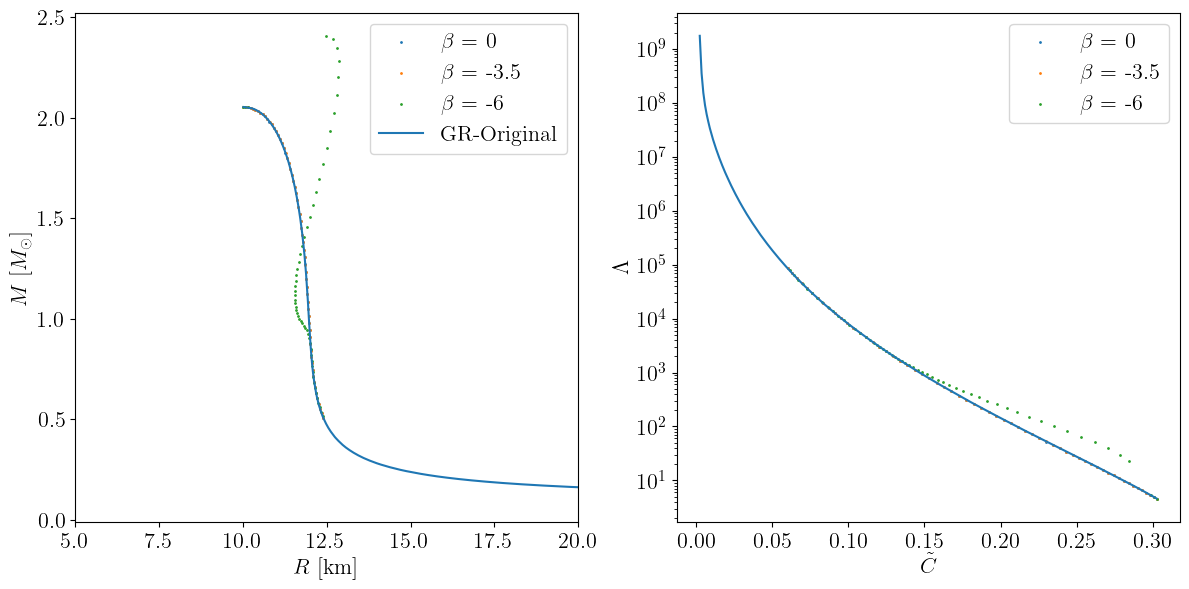

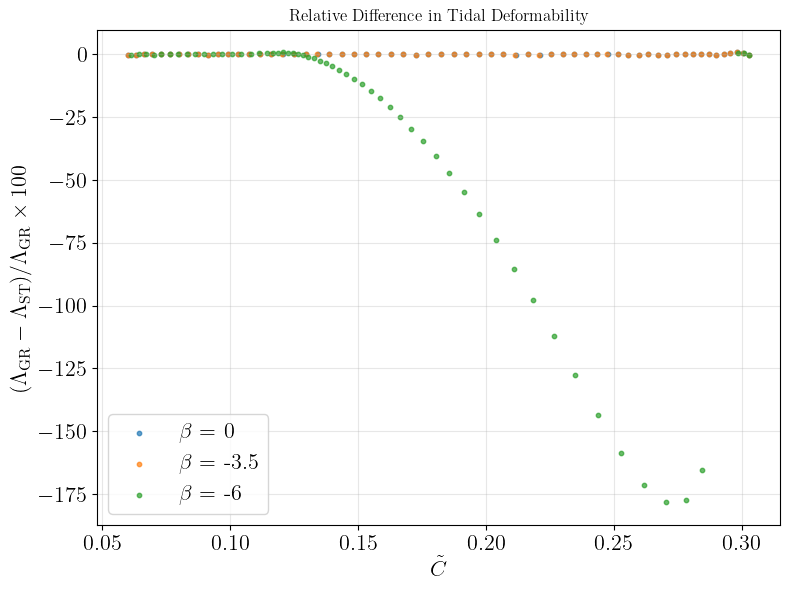

In [4]:
# jax.config.update("jax_disable_jit", True)
# Solve TOV equations for multiple beta values:
# beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# beta_values = [-6, -5,0]
beta_values = [-6,-3.5,0]
# initial guess
phi_c = 1
phi_inf_tgt = 1e-3

results = {}  # store computed families keyed by beta

# Reverse order
for i, beta_ST in enumerate(reversed(beta_values), start=1):
    print(f"[{i}/{len(beta_values)}] Running beta = {beta_ST} ...")

    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, phi_inf_tgt)
    logpc, masses, radii, LambdasT, LambdasS, LambdasST1, LambdasST2 = construct_family_ST_Greci(eos_tuple_ST, ndat=100, min_nsat=0.5)

    # Mask to avoid low-mass branch
    m_min = 0.5
    mask = masses > m_min

    results[beta_ST] = {
        "masses": masses[mask],
        "radii": radii[mask],
        "LambdasT": LambdasT[mask],
        "LambdasS": LambdasS[mask],
        "LambdasST1": LambdasST1[mask],
        "LambdasST2": LambdasST2[mask],
        "pcs" : jnp.exp(logpc[mask]),
    }

print("All beta values done !!")


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)

eos_tuple = (ns, ps, hs, es, dloge_dlogps)
logpc, masses, radii, LambdasT = construct_family(eos_tuple, ndat=300, min_nsat=0.5)
# Limit masses to be above certain mass to make plot prettier
m_min = 0.1
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
LambdasT = LambdasT[mask]
pc = jnp.exp(logpc[mask])

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original')

plt.xlabel(r"$R$ [km]")
plt.xlim(5,20)
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, jnp.abs(data["LambdasT"]), label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["LambdasT"],data["masses"], data["radii"] * 1e3)
plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), LambdasT) #temporary hide it
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

# New plot: Relative difference in tidal deformability
plt.figure(figsize=(8, 6))

# Compute GR compactness and Lambda for interpolation
C_GR = masses * utils.solar_mass_in_meter / (radii * 1e3)

# Create interpolation function for GR Lambda vs C
from scipy.interpolate import interp1d
Lambda_GR_interp = interp1d(C_GR, LambdasT, bounds_error=False, fill_value="extrapolate")

for beta_ST, data in results.items():
    # Compute compactness for ST case
    C_ST = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    
    # Get GR Lambda at the same compactness values
    Lambda_GR_at_C = Lambda_GR_interp(C_ST)
    
    # relative difference: (Lambda_GR - Lambda_ST) / Lambda_GR
    rel_diff = (Lambda_GR_at_C - data["LambdasT"]) / Lambda_GR_at_C *100
    
    plt.scatter(C_ST, rel_diff, label=rf'$\beta$ = {beta_ST}', s=10, alpha=0.7)

plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$(\Lambda_{\mathrm{GR}} - \Lambda_{\mathrm{ST}}) / \Lambda_{\mathrm{GR}} \times 100$")
plt.title("Relative Difference in Tidal Deformability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



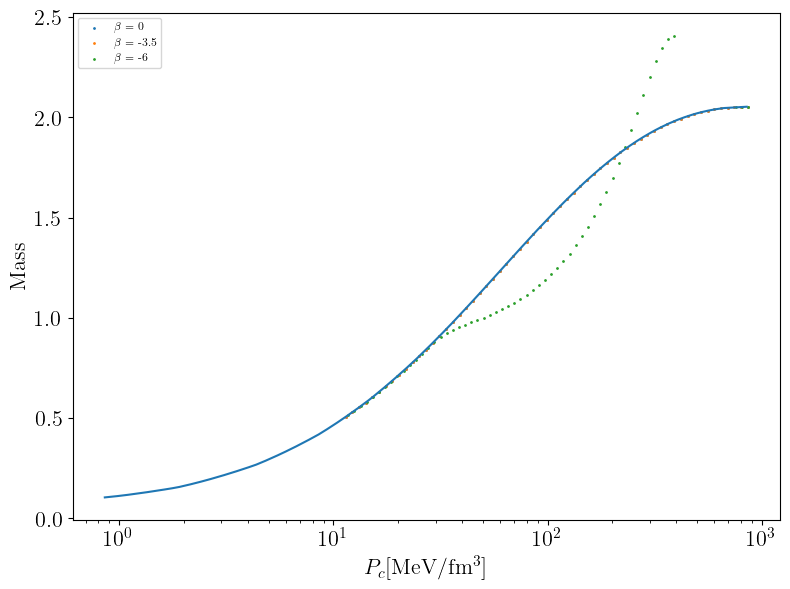

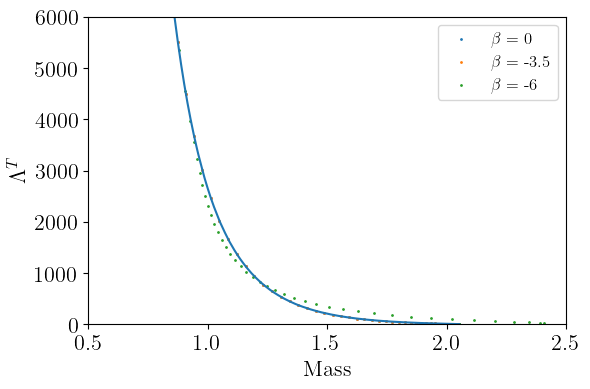

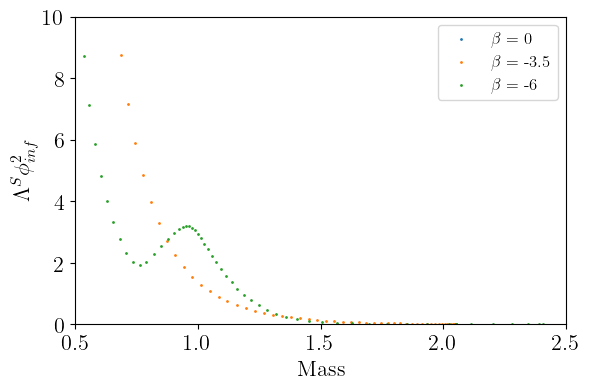

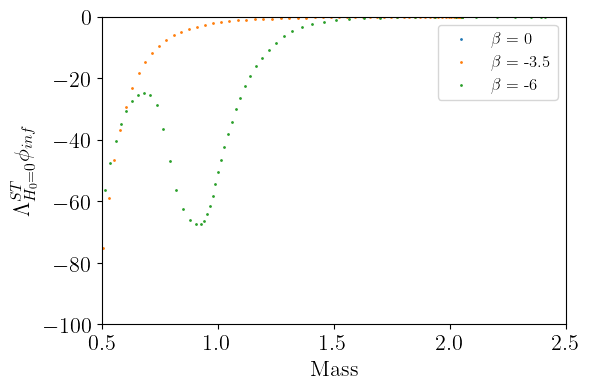

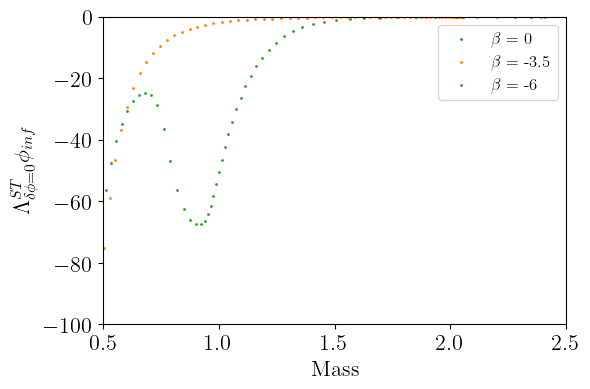

In [7]:
plt.figure(figsize=(8, 6))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    pcs = data["pcs"] 
    plt.scatter(pcs*utils.geometric_to_MeV_fm_inv3, data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
plt.plot(pc*utils.geometric_to_MeV_fm_inv3, masses) #temporary hide it
plt.ylabel(r"Mass")
plt.xlabel(r"$P_c$[MeV/fm$^3$]")
plt.yscale("linear")
plt.xscale("log")
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasT"]
    plt.scatter(data["masses"],lam, label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
plt.plot(masses, Lambdas) #temporary hide it
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^T$")
plt.ylim(0,6000)
plt.xlim(0.5,2.5)
# plt.yscale("linear")
# plt.yscale("log")
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasS"]
    plt.scatter(data["masses"],lam*1e-6, label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
# plt.plot(masses, Lambdas) #temporary hide it
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^S \phi_{inf}^2$")
plt.ylim(0,10)
plt.xlim(0.5,2.5)
# plt.yscale("linear")
# plt.yscale("log")
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasST1"]
    plt.scatter(data["masses"],lam*1e-3, label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
# plt.plot(masses, Lambdas) #temporary hide it
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^{ST}_{H_0 = 0} \phi_{inf}$")
plt.ylim(-100,0)
plt.xlim(0.5,2.5)
# plt.yscale("linear")
# plt.yscale("log")
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6, 4))
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    lam = data["LambdasST2"]
    plt.scatter(data["masses"],lam*1e-3, label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
# plt.plot(masses, Lambdas) #temporary hide it
plt.xlabel(r"Mass")
plt.ylabel(r"$\Lambda^{ST}_{\delta \phi = 0} \phi_{inf}$")
plt.ylim(-100,0)
plt.xlim(0.5,2.5)
# plt.yscale("linear")
# plt.yscale("log")
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

In [6]:
usa asdnj aijso
FPS failed....

SyntaxError: invalid syntax (2602277512.py, line 1)

# Equation of state

In [ ]:
nsat = 0.16 # nuclear saturation density in fm^-3

# Define the EOS object, here we focus on Metamodel with CSE
eos = MetaModel_with_CSE_EOS_model(nmax_nsat=6.0)

# Define the nuclear empirical parameters (NEPs) -- all in MeV
NEP_dict = {"E_sat": -16.0, # saturation parameters
            "K_sat": 200.0,
            "Q_sat": 0.0,
            "Z_sat": 0.0,
            "E_sym": 32.0, # symmetry parameters
            "L_sym": 40.0,
            "K_sym": -100.0,
            "Q_sym": 0.0,
            "Z_sym": 0.0,
            }

# Define the breakdown density -- this is usually between 1-2 nsat
nbreak = 1.5 * nsat
NEP_dict["nbreak"] = nbreak

# Then we extend with some CSE grid points
ngrids = jnp.array([2.0, 3.0, 4.0, 5.0]) * nsat
cs2grids = jnp.array([0.3, 0.4, 0.3, 0.2]) # speed of sound squared at the grid points

# Now create the EOS -- returns a tuple with most useful EOS quantities
ns, ps, hs, es, dloge_dlogps, mu, cs2 = eos.construct_eos(NEP_dict, ngrids, cs2grids)

# Make a plot
plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

# For the plot, let's make some conversions to more common units
ns_plots = ns / utils.fm_inv3_to_geometric / 0.16
es_plots = es / utils.MeV_fm_inv3_to_geometric
ps_plots = ps / utils.MeV_fm_inv3_to_geometric

# p(n)
plt.subplot(221)
plt.plot(ns_plots, ps_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")

# e(n)
plt.subplot(222)
plt.plot(ns_plots, es_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$e$ [MeV/fm$^3$]")

# cs2(n)
plt.subplot(223)
plt.plot(ns_plots, cs2)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$c_s^2$")
plt.axvline(0.5, color = "red", label = "Crust-core transition")
plt.axvline(nbreak / nsat, color = "black", label = r"$n_{\rm{break}}$")
plt.legend()

# p(e)
plt.subplot(224)
plt.plot(es_plots, ps_plots)
plt.xlabel(r"$e$ [MeV/fm$^3$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.tight_layout()
plt.show()
plt.close()

# Run Comparison
## First Compile
GR: 3.673259 s (1 iter, 1 call)

ST w/ damped iter: 16.859454 s (113 iter, 114 call)

ST w/ Newtonian, jacrev(): 22.624507 s (3 iter, unknown call)

ST w/ Newtonian, finite difference Jacobian: 3.424953 s (3 iter, 10 call)

ST w/ Newtonian, step difference Jacobian, diagonal matrix approximation: Elapsed time: 0.971096 s (5 iter, 6 call)

## Second run, compiled at first run
GR: 0.064295 s

ST w/ damped iter: 1.000334 s

ST w/ Newtonian, jacrev(): 6.014499 s

ST w/ Newtonian, finite difference Jacobian: 1.794891 s

ST w/ Newtonian, damped iter + step difference Jacobian, diagonal matrix approximation: Elapsed time: 0.865627  s


# Neutron stars

In [ ]:
# Solve TOV equations:
eos_tuple = (ns, ps, hs, es, dloge_dlogps)


start = time.perf_counter()
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat = 50, min_nsat = 1.0)
end = time.perf_counter()

print(f"Elapsed time: {end - start:.6f} s")
# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Limit masses to be above certain mass to make plot prettier
m_min = 0.1
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.plot(masses, Lambdas)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# jax.config.update("jax_disable_jit", True)
# Solve TOV equations for multiple beta values:
# beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# beta_values = [-6, -5,0]
# beta_values = [-6,-4.5,0]
beta_values = [-5.5, -5.25, -5.0]
# initial guess
phi_c = 1
phi_inf_tgt = 1e-3

results = {}  # store computed families keyed by beta

# Reverse order
for i, beta_ST in enumerate(reversed(beta_values), start=1):
    print(f"[{i}/{len(beta_values)}] Running beta = {beta_ST} ...")

    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, phi_inf_tgt)
    logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple_ST, ndat=300, min_nsat=0.5)

    # Mask to avoid low-mass branch
    m_min = 0.5
    mask = masses > m_min

    results[beta_ST] = {
        "masses": masses[mask],
        "radii": radii[mask],
        "Lambdas": Lambdas[mask]
    }

print("All beta values done !!")


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)

eos_tuple = (ns, ps, hs, es, dloge_dlogps)
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat=300, min_nsat=0.5)
# Limit masses to be above certain mass to make plot prettier
m_min = 0.1
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original')

plt.xlabel(r"$R$ [km]")
plt.xlim(5,20)
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, jnp.abs(data["Lambdas"]), label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
# plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), Lambdas) #temporary hide it
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

# New plot: Relative difference in tidal deformability
plt.figure(figsize=(8, 6))

# Compute GR compactness and Lambda for interpolation
C_GR = masses * utils.solar_mass_in_meter / (radii * 1e3)

# Create interpolation function for GR Lambda vs C
from scipy.interpolate import interp1d
Lambda_GR_interp = interp1d(C_GR, Lambdas, bounds_error=False, fill_value="extrapolate")

for beta_ST, data in results.items():
    # Compute compactness for ST case
    C_ST = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    
    # Get GR Lambda at the same compactness values
    Lambda_GR_at_C = Lambda_GR_interp(C_ST)
    
    # relative difference: (Lambda_GR - Lambda_ST) / Lambda_GR
    rel_diff = (Lambda_GR_at_C - data["Lambdas"]) / Lambda_GR_at_C *100
    
    plt.scatter(C_ST, rel_diff, label=rf'$\beta$ = {beta_ST}', s=10, alpha=0.7)

plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$(\Lambda_{\mathrm{GR}} - \Lambda_{\mathrm{ST}}) / \Lambda_{\mathrm{GR}} \times 100$")
plt.title("Relative Difference in Tidal Deformability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# jax.config.update("jax_disable_jit", True)
# Solve TOV equations for multiple beta values:
beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# beta_values = [-6, -5,0]
# beta_values = [-5,0]
# initial guess
phi_c = -1
nu_c = -1.2

results = {}  # store computed families keyed by beta

# Reverse order
for i, beta_ST in enumerate(reversed(beta_values), start=1):
    print(f"[{i}/{len(beta_values)}] Running beta = {beta_ST} ...")

    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, nu_c)
    logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple_ST, ndat=50, min_nsat=0.5)

    # Mask to avoid low-mass branch
    m_min = 0.5
    mask = masses > m_min

    results[beta_ST] = {
        "masses": masses[mask],
        "radii": radii[mask],
        "Lambdas": Lambdas[mask]
    }

print("All beta values done ✅")


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)


# M(R) plot
plt.subplot(121)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, data["Lambdas"], label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()


In [ ]:
# jax.config.update("jax_disable_jit", True)
# Solve TOV equations for multiple beta values:
beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# beta_values = [-6, -5,0]
# beta_values = [-5,0]
# initial guess
phi_c = -1
nu_c = -1.2

results = {}  # store computed families keyed by beta

# Reverse order
for i, beta_ST in enumerate(reversed(beta_values), start=1):
    print(f"[{i}/{len(beta_values)}] Running beta = {beta_ST} ...")

    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, nu_c)
    logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple_ST, ndat=100, min_nsat=0.5)

    # Mask to avoid low-mass branch
    m_min = 0.5
    mask = masses > m_min

    results[beta_ST] = {
        "masses": masses[mask],
        "radii": radii[mask],
        "Lambdas": Lambdas[mask]
    }

print("All beta values done ✅")


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)


logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat=50, min_nsat=1.5)
# Limit masses to be above certain mass to make plot prettier
m_min = 0.1
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original')

plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, data["Lambdas"], label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), Lambdas)
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()


In [ ]:
# jax.config.update("jax_disable_jit", True)
# Solve TOV equations for multiple beta values:
beta_values = [-6,-5.5, -5.0, -4.5, -4.0, -3.5, 0]
# beta_values = [-6, -5,0]
# beta_values = [-6,-4.5,0]
# initial guess
phi_c = 1
nu_c = -1.2

results = {}  # store computed families keyed by beta

# Reverse order
for i, beta_ST in enumerate(reversed(beta_values), start=1):
    print(f"[{i}/{len(beta_values)}] Running beta = {beta_ST} ...")

    eos_tuple_ST = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, nu_c)
    logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple_ST, ndat=300, min_nsat=0.5)

    # Mask to avoid low-mass branch
    m_min = 0.5
    mask = masses > m_min

    results[beta_ST] = {
        "masses": masses[mask],
        "radii": radii[mask],
        "Lambdas": Lambdas[mask]
    }

print("All beta values done !!")


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# M(R) plot
plt.subplot(121)
for beta_ST, data in results.items():
    plt.scatter(data["radii"], data["masses"], label=rf'$\beta$ = {beta_ST}',s=1)

eos_tuple = (ns, ps, hs, es, dloge_dlogps)
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat=300, min_nsat=0.5)
# Limit masses to be above certain mass to make plot prettier
m_min = 0.1
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses, label='GR-Original')

plt.xlabel(r"$R$ [km]")
plt.xlim(5,20)
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()
# Λ(C) plot
plt.subplot(122)
for beta_ST, data in results.items():
    # compactness: C = GM/(Rc^2) = (M * solar_mass_in_meter) / (R in meters)
    C = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    plt.scatter(C, jnp.abs(data["Lambdas"]), label=rf'$\beta$ = {beta_ST}',s=1)
    # print(data["Lambdas"],data["masses"], data["radii"] * 1e3)
# plt.plot(masses* utils.solar_mass_in_meter /(radii* 1e3), Lambdas) #temporary hide it
plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

# New plot: Relative difference in tidal deformability
plt.figure(figsize=(8, 6))

# Compute GR compactness and Lambda for interpolation
C_GR = masses * utils.solar_mass_in_meter / (radii * 1e3)

# Create interpolation function for GR Lambda vs C
from scipy.interpolate import interp1d
Lambda_GR_interp = interp1d(C_GR, Lambdas, bounds_error=False, fill_value="extrapolate")

for beta_ST, data in results.items():
    # Compute compactness for ST case
    C_ST = data["masses"] * utils.solar_mass_in_meter / (data["radii"] * 1e3)
    
    # Get GR Lambda at the same compactness values
    Lambda_GR_at_C = Lambda_GR_interp(C_ST)
    
    # relative difference: (Lambda_GR - Lambda_ST) / Lambda_GR
    rel_diff = (Lambda_GR_at_C - data["Lambdas"]) / Lambda_GR_at_C *100
    
    plt.scatter(C_ST, rel_diff, label=rf'$\beta$ = {beta_ST}', s=10, alpha=0.7)

plt.xlabel(r"$\tilde{C}$")
plt.ylabel(r"$(\Lambda_{\mathrm{GR}} - \Lambda_{\mathrm{ST}}) / \Lambda_{\mathrm{GR}} \times 100$")
plt.title("Relative Difference in Tidal Deformability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()